In [82]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

## Load Data

In [83]:
# Load the data
train_data = torchvision.datasets.MNIST(root='/data', train=True, download=False, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/data', train=False, download=False, transform=torchvision.transforms.ToTensor())

In [84]:
# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)


## Create Autoencoder Model

In [85]:
LATENT_DIM = 10

# Define the model
model = nn.Sequential(# Encoder
                      nn.Linear(784, 512),
                      nn.SiLU(),
                      nn.Linear(512, 128),
                      nn.SiLU(),
                      nn.Linear(128, 64),
                      nn.SiLU(),
                      nn.Linear(64, 16),
                      nn.SiLU(),
                      nn.Linear(16, LATENT_DIM),
                      # Decoder
                      nn.Linear(LATENT_DIM, 16),
                      nn.SiLU(),
                      nn.Linear(16, 64),
                      nn.SiLU(),
                      nn.Linear(64, 128),
                      nn.SiLU(),
                      nn.Linear(128, 512),
                      nn.SiLU(),
                      nn.Linear(512, 784)
                     )

In [86]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Training Loop

In [87]:
loss_values = []
# Train the model
epochs = 15
for e in range(epochs):
    
    running_loss = 0
    for images, labels in train_loader:
        
        # Flatten the images
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)
        
        # Calculate the loss
        loss = loss_fn(output, images)
        
        # Backward pass
        loss.backward()
        loss_values.append(loss.item())
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()  
        
    print(f"EPOCH:{e} | Training loss: {running_loss/len(train_loader)}")

EPOCH:0 | Training loss: 0.07428237340868787
EPOCH:1 | Training loss: 0.06011758064653011
EPOCH:2 | Training loss: 0.055829662132136366
EPOCH:3 | Training loss: 0.05233147979733792
EPOCH:4 | Training loss: 0.04789248205562855
EPOCH:5 | Training loss: 0.04550410997360311
EPOCH:6 | Training loss: 0.04331930138646288
EPOCH:7 | Training loss: 0.03984031342762582
EPOCH:8 | Training loss: 0.03799391832757503
EPOCH:9 | Training loss: 0.036640839912789935
EPOCH:10 | Training loss: 0.03517003395455949
EPOCH:11 | Training loss: 0.03362429847425603
EPOCH:12 | Training loss: 0.032613577971116026
EPOCH:13 | Training loss: 0.031843527509494034
EPOCH:14 | Training loss: 0.031231816350779634


## Loss Curve

In [88]:
# Plot the loss curve
px.line(y=loss_values, title='Loss Curve')

In [89]:
# Save the model
torch.save(model.state_dict(), 'autoencoder_model_'+ str(LATENT_DIM) +'d.pth')

## Test Data

In [90]:
# Sort test data by label
test_data_by_label = {}
for image, label in test_data:
    if label not in test_data_by_label:
        test_data_by_label[label] = []
    test_data_by_label[label].append(image)

In [91]:
test_data_by_label[1][0].shape

torch.Size([1, 28, 28])

## Compare Original Data and Reconstructed Data

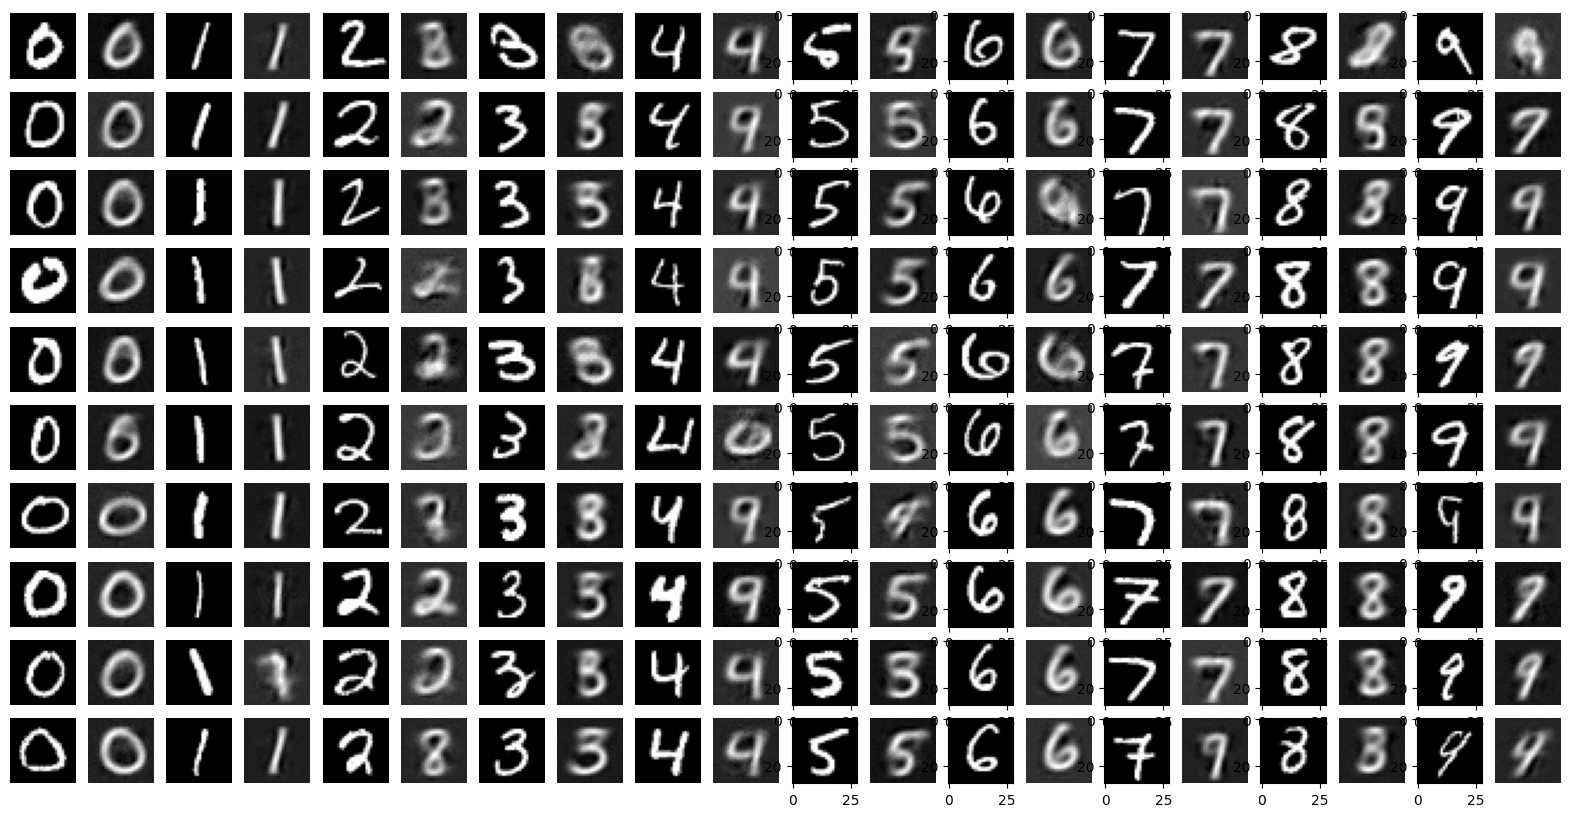

In [92]:
# Test the model
fig, axes = plt.subplots(nrows=10, ncols=20)

for i in range(10):
    for j in range(10):
        output_img = model(test_data_by_label[j][i].squeeze().flatten())

        axes[i][2*j].imshow(test_data_by_label[j][i].squeeze(), cmap='gray') # Original image
        axes[i][j].axis('off')
        axes[i][2*j+1].imshow(output_img.reshape(28, 28).detach().numpy(), cmap='gray') # Reconstructed image
        axes[i][2*j+1].axis('off')
fig.set_size_inches(20, 10)

In [93]:
# output_images = []
# for image, label in test_data:
#     image = image.view(image.shape[0], -1)
#     output_image = model(image)
#     output_images.append(output_image.detach().numpy())

## Visualize Latent Space

In [94]:
list(model.children())[:-9]

[Linear(in_features=784, out_features=512, bias=True),
 SiLU(),
 Linear(in_features=512, out_features=128, bias=True),
 SiLU(),
 Linear(in_features=128, out_features=64, bias=True),
 SiLU(),
 Linear(in_features=64, out_features=16, bias=True),
 SiLU(),
 Linear(in_features=16, out_features=10, bias=True)]

In [95]:
# Proscess all the test images, get activation values and middle layer values
new_model = nn.Sequential(*list(model.children())[:-9]).to('cpu')

In [96]:
# Get the latent space representation
latent_space = []
for image, label in test_data:
    image = image.view(image.shape[0], -1)
    latent_vector = new_model(image) # 3D vector
    latent_space.append(latent_vector.squeeze().detach().numpy())

In [97]:
latent_space = np.array(latent_space)
latent_space.shape

(10000, 10)

In [105]:
# Createa a dataframe
columns = []

if LATENT_DIM == 2:
    df = pd.DataFrame(latent_space, columns=['x', 'y'])
elif LATENT_DIM == 3:
    df = pd.DataFrame(latent_space, columns=['x', 'y', 'z'])
else:
    df = pd.DataFrame(latent_space)
df['label'] = test_data.targets.numpy().astype(str)
# Sort df by label
df = df.sort_values(by=['label'])
df['index'] = df.index
df.head()


,0,1,2,3,4,5,6,7,8,9,label,index
4999,7.945997,21.398491,-11.796691,58.721371,-22.071810,33.472755,8.335688,-25.990566,-89.322609,-62.361156,0,4999
7747,1.375080,15.727093,-0.079745,42.642258,1.435386,11.001016,-6.015726,-7.317479,-46.459034,-38.671749,0,7747
1297,-1.818385,12.652208,-13.737151,48.504242,-13.635834,30.675636,4.484671,-14.824018,-81.033890,-57.053272,0,1297
9311,2.780217,10.837126,-7.445997,43.314018,-7.567039,27.092411,2.755099,-13.364335,-63.359631,-44.489456,0,9311
1294,-4.246914,12.769865,-12.903992,43.213501,-11.288855,25.732258,2.457523,-8.824996,-73.306572,-53.275986,0,1294


In [99]:
# Plot the latent space
if LATENT_DIM == 2:
    fig = px.scatter(df, x='x', y='y', color='label', hover_data={'x':False, 'y':False, 'label':True, 'index':True}, width=800, height=800)
    fig.show()
elif LATENT_DIM == 3:
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', hover_data={'x':False, 'y':False, 'z':False, 'label':True, 'index':True}, width=800, height=800)
    fig.show()

## Interpolate between two points in the latent space

In [106]:
# Get avg latent vector for each label
avg_latent_vectors = [0]*10
# Iterate over df and get avg latent vector for each label
for i in range(10):
    avg_latent_vectors[i] = df[df['label'] == str(i)].mean().values[:-2]
avg_latent_vectors

[array([-2.241320848464966, 13.04951286315918, -9.611674308776855,
        43.28232192993164, -8.842785835266113, 21.75296401977539,
        0.8252235651016235, -11.093794822692871, -66.56144714355469,
        -49.05003356933594], dtype=object),
 array([-9.66451644897461, 4.803526878356934, -6.9902167320251465,
        6.575296401977539, -1.8938039541244507, 0.4977687895298004,
        -2.9620625972747803, 7.640266418457031, -18.990331649780273,
        -16.426067352294922], dtype=object),
 array([-10.635668754577637, 11.215021133422852, -14.692331314086914,
        23.869775772094727, -11.229129791259766, 15.300491333007812,
        1.2807456254959106, 5.488941192626953, -54.476463317871094,
        -42.934791564941406], dtype=object),
 array([-10.002717971801758, 8.257085800170898, -16.25078773498535,
        28.283870697021484, -13.3427095413208, 18.32891273498535,
        3.3121676445007324, -4.5613884925842285, -62.66462707519531,
        -45.577232360839844], dtype=object),
 arra

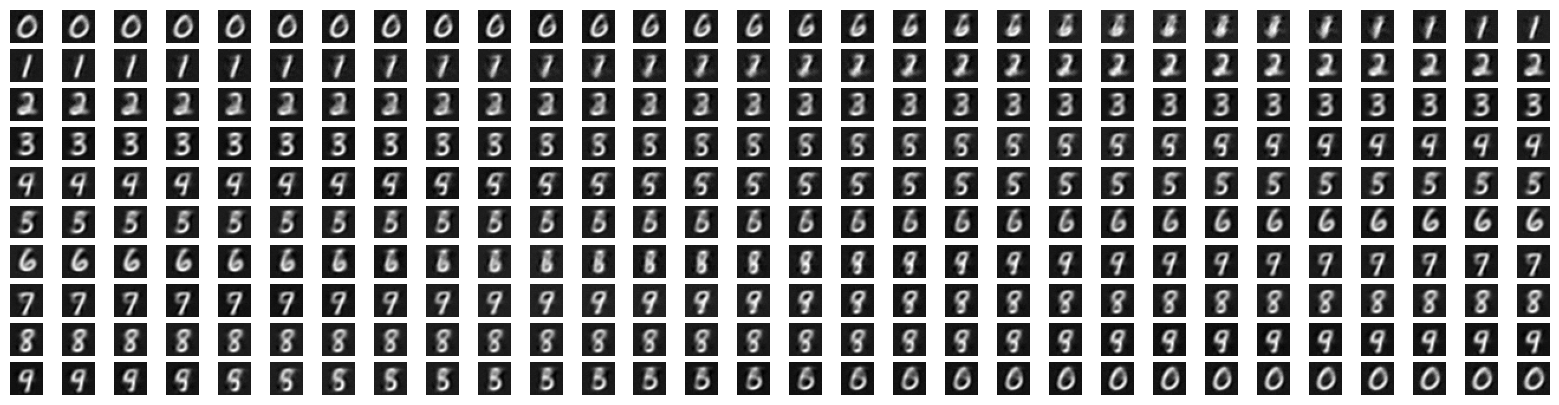

In [131]:
# 0 -> 6 -> 1 -> 7 -> 8

interpolation = []
SELECT_LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
NUM_STEPS = 30

for i in range(len(SELECT_LABELS)-1):
    for j in range(NUM_STEPS):
        interpolation.append(avg_latent_vectors[SELECT_LABELS[i]] + (avg_latent_vectors[SELECT_LABELS[i+1]] - avg_latent_vectors[SELECT_LABELS[i]]) * (j/NUM_STEPS))
interpolation = np.array(interpolation)
interpolation=np.vstack(interpolation).astype(float)

# Plot output images
output_model = nn.Sequential(*list(model.children())[-9:]).to('cpu')
interpolate_images = output_model(torch.from_numpy(interpolation).float()).detach().numpy()
# Plot the images
fig, axes = plt.subplots(nrows=len(SELECT_LABELS) - 1, ncols=NUM_STEPS)
for i in range(len(SELECT_LABELS)-1):
    for j in range(NUM_STEPS):
        axes[i][j].imshow(interpolate_images[i*NUM_STEPS+j].reshape(28, 28), cmap='gray')
        axes[i][j].axis('off')

fig.set_size_inches(20, 5)

In [137]:
# Maka a gif
import imageio

# for i in range(len(SELECT_LABELS)-1):
#     for j in range(NUM_STEPS):
#         plt.imshow(interpolate_images[i*NUM_STEPS+j].reshape(28, 28), cmap='gray')
#         plt.axis('off')
#         plt.savefig('./interpolation_img/img'+ str(i) + str(j) + '.png', bbox_inches='tight')
#         plt.close()

frames = []
for i in range(len(SELECT_LABELS)-1):
    for j in range(NUM_STEPS):
        image = imageio.imread('./interpolation_img/img'+ str(i) + str(j) + '.png')
        frames.append(image)
imageio.mimsave('./interpolation_img/interpolation_2.gif', frames, loop=1)

C:\Users\katti\AppData\Local\Temp\ipykernel_31844\1939171445.py:14: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [ ]:
avg_df = pd.DataFrame(avg_latent_vectors, columns=['x', 'y', 'z'])
avg_df['label'] = avg_df.index.astype(str)
avg_df

,x,y,z,label
0,-45.273056,37.736229,-41.888561,0
1,-13.867578,-4.320614,1.036613,1
2,-32.477951,8.532671,-23.758261,2
3,-30.168396,14.310102,-17.775814,3
4,-16.354460,3.992481,-21.865646,4
5,-29.995300,11.614689,-20.151564,5
6,-20.807180,16.731613,-26.556652,6
7,-18.754532,-2.865340,-18.538074,7
8,-34.209194,8.524223,-20.006069,8
9,-15.153541,2.304877,-18.914736,9


In [ ]:
# Plot the avg latent vectors
if LATENT_DIM == 2:
    fig = px.scatter(avg_df, x='x', y='y', color='label', hover_data={'x':False, 'y':False, 'label':True}, width=800, height=800)
elif LATENT_DIM == 3:
    fig = px.scatter_3d(avg_df, x='x', y='y', z='z', color='label', hover_data={'x':False, 'y':False, 'z':False, 'label':True}, width=800, height=800)
fig.show()